In [1]:
import argparse
import yaml
import os

import sys
# Add the parent directory of the notebook to the path
sys.path.append(os.path.abspath("../.."))

import matplotlib.pyplot as plt

import json
import numpy as np
import pyarrow.parquet as pq
import awkward as ak
import vector
vector.register_awkward()
import torch
import torch.nn.functional as F


from evenet.control.global_config import global_config
from evenet.dataset.preprocess import process_event_batch, convert_batch_to_torch_tensor
from evenet.network.evenet_model import EveNetModel
from evenet.utilities.diffusion_sampler import DDIMSampler


from helpers.physics_functions import get_bins
from helpers.basic_fit import plot_mass_distribution
from helpers.flow_sampling import get_mass_samples
from helpers.stats_functions import curve_fit_m_inv, parametric_fit, check_bkg_for_peaks, calculate_test_statistic
from helpers.plotting import read_feature, newplot, hist_with_outline, hist_with_errors, function_with_band, stamp
from helpers.utils import save_file


from rich.progress import Progress, BarColumn, TimeRemainingColumn

from preprocessing.preprocess import unflatten_dict
from functools import partial

/global/homes/t/tihsu/.conda/envs/ray/lib/python3.12/site-packages/zfit/__init__.py:60: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn(
2025-04-27 14:09:08.231682: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-27 14:09:08.383718: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-27 14:09:08.383738: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-27 14:09

In [2]:
config_workflow = "config/workflow_toy_model.yaml"
device = "cpu"
with open(config_workflow) as f:
    config = yaml.safe_load(f)
step_dir = "step2_bump_hunting"
global_config.load_yaml(config["train-cls"]["config"])
with open(config["input"]["event_info"]) as f:
    event_info = yaml.safe_load(f)

kfold = 5


In [12]:
def predict(config,
            split,
            checkpoint,
            inputdir,
            inputdir_SB,
            event_info,
            global_config,
            device):
    os.makedirs(os.path.join(config["output"]["plotdir"], step_dir), exist_ok=True)
    checkpoint = torch.load(checkpoint, map_location=device)
    normalization_dict = torch.load(os.path.join(inputdir, "normalization.pt"))
    shape_metadata = json.load(open(os.path.join(inputdir, "shape_metadata.json")))
    model = EveNetModel(
        config = global_config,
        device = torch.device(device),
        normalization_dict=normalization_dict,
        classification=True
    ).to(device)
    new_state_dict = dict()
    for k, v in checkpoint["state_dict"].items():
        new_state_dict[k.replace("model.", "")] = v
    model.load_state_dict(new_state_dict)
    model.eval()
    df_dummy_SB = pq.read_table(
        os.path.join(inputdir_SB, "data.parquet")
    ).to_pandas()
    df_dummy_SB.sample(frac=1).reset_index(drop=True)
    df_dummy_SR = pq.read_table(
        os.path.join(inputdir, "data.parquet")
    ).to_pandas()
    df_dummy_SR.sample(frac=1).reset_index(drop=True)
    norm_dict = torch.load(os.path.join(config["output"]["storedir"], "SB", "normalization.pt"))
    
    
    df_SB = process_event_batch(
        df_dummy_SB,
        shape_metadata=shape_metadata,
        unflatten=unflatten_dict,
    )
    
    df_SR = process_event_batch(
        df_dummy_SR,
        shape_metadata=shape_metadata,
        unflatten=unflatten_dict,
    )

    num_SB = df_SB["x"].shape[0]
    num_SR = df_SR["x"].shape[0]

    start_SB = int(split[0] * num_SB)
    end_SB = int(split[1] * num_SB)
    start_SR = int(split[0] * num_SR)
    end_SR = int(split[1] * num_SR)
    
    df_SB = {k: v[start_SB:end_SB] for k, v in df_SB.items()}
    df_SR = {k: v[start_SR:end_SR] for k, v in df_SR.items()}

    df_SR = {k: v[df_SR["classification"] == 1] for k,v in df_SR.items()}
    df_data = {k: np.concatenate([df_SB[k], df_SR[k]]) for k in df_SB}
    
    batch = convert_batch_to_torch_tensor(df_data)
    batch = {k: v for k, v in batch.items()}

    batch_size = 1024
    total_event = batch['x'].shape[0]

    num_processed_sample = 0
    results = []
    with Progress(
            "[progress.description]{task.description}",
            BarColumn(),
            "[progress.percentage]{task.percentage:>3.0f}%",
            "•",
            TimeRemainingColumn(),
    ) as progress:
        task = progress.add_task("Evaluating samples...", total=total_event)
    
        while num_processed_sample < total_event:
            with torch.no_grad():
                batch_num = max(min(total_event - num_processed_sample, batch_size) , 1)
                batch_input = {k: v[num_processed_sample: num_processed_sample + batch_num].to(device) for k, v in batch.items()}
                output = model(batch_input, time = torch.zeros((batch_input["x"].shape[0]), device=device))
                num_processed_sample += batch_num
                results.append(output["classification"])

    results = np.concatenate([F.softmax(v["classification/signal"], dim=-1).detach().cpu().numpy() for v in results])
    df_data["mva_score"] = results[:, 1]
    
    return df_data

In [13]:
def clean_and_append(dirname, postfix):
    if dirname.endswith("/"):
        dirname = dirname[:-1]
    return dirname + postfix

In [14]:
postfix = "_hybrid_no_signal"
postfix_SB = "_no_signal"
data_processed = dict()
for fold in range(kfold):
    print(f"process {fold} fold")
    folddir = f"fold_{fold}"
    inputdir =  os.path.join(clean_and_append(config["output"]["storedir"], postfix), "SR")
    inputdir_SB =  os.path.join(clean_and_append(config["output"]["storedir"], postfix_SB), "SB")
    files = sorted(
        (os.path.join(inputdir, folddir, f) for f in os.listdir(os.path.join(inputdir, folddir))),
        key=os.path.getmtime,
        reverse=True
    )
    split = [fold * (1.0 / kfold), (fold+1) * (1.0 / kfold)]
    data = predict(config = config,
            split = split,
            checkpoint = files[0],
            inputdir = inputdir,
            inputdir_SB = inputdir_SB,
            event_info = event_info,
            global_config = global_config,
            device = device
           )
    for k,v in data.items():
        if k not in data_processed:
            data_processed[k] = []
        data_processed[k].append(v)

process 0 fold


Output()

process 1 fold


Output()

process 2 fold


Output()

process 3 fold


Output()

process 4 fold


Output()

In [15]:
df_data = {k: np.concatenate(v) for k, v in data_processed.items()}

In [16]:
jet = ak.from_regular(vector.zip(
    {
        "pt": ak.from_numpy(read_feature(df_data["x"], event_info, 'pt')),
        "eta": ak.from_numpy(read_feature(df_data["x"], event_info, 'eta')),
        "phi": ak.from_numpy(read_feature(df_data["x"], event_info, 'phi')),
        "mass": ak.from_numpy(read_feature(df_data["x"], event_info, 'mass')),
    }
))

In [17]:
df_data["inv_mass"] = (jet[...,0] + jet[...,1]).mass.to_numpy()

In [18]:
from joblib import Parallel, delayed
def plot_histograms_with_fits(
    fpr_thresholds,
    data_dict,
    fit_degree,
    title,
    SB_left,
    SR_left,
    SR_right,
    SB_right, 
    num_bins_SR,
    n_folds= 5,
    take_score_avg=True,
    latex_flag=False,
    ymin = 1.0,
    ymax = 1e5,
    ncpu = 1,
    legend_title = r"$\bf{CMS 2016 Open Data: Dimuons}$",
    fit = False
):
    

    save_data = {}
    save_data["fpr_thresholds"] = fpr_thresholds
    save_data["fit_degree"] = fit_degree
    save_data["num_bins_SR"] = num_bins_SR
    save_data["popts"] = []
    save_data["pcovs"] = []
    save_data["significances"] = []
    save_data["filtered_masses"] = []
    save_data["y_vals"] = []


    # define bins and bin edges for the SB and SR
    # change the bin width with `num_bins_SR`
    plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins(SR_left, SR_right, SB_left, SB_right, num_bins_SR = num_bins_SR)

    # Get a list of all possible cuts for the feature

    all_scores = data_dict["mva_score"]
    all_masses = data_dict["inv_mass"]
    in_SR = (all_masses >= SR_left ) & (all_masses <= SR_right)
    in_SBL = (all_masses < SR_left )
    in_SBH = (all_masses > SR_right )

    mass_SBL = all_masses[in_SBL]
    mass_SR = all_masses[in_SR]
    mass_SBH = all_masses[in_SBH]

    feature_SBL = all_scores[in_SBL]
    feature_SR = all_scores[in_SR]
    feature_SBH = all_scores[in_SBH]

    feature_cut_points = np.linspace(np.min(all_scores), np.max(all_scores), 10000)
    # For each cut, calculate the number of signal and background events in the SR
    num_in_SBL = []
    num_in_SR = []
    num_in_SBH = []
    FPR = []
    for cut in feature_cut_points:
        num_in_SBL.append(np.sum(feature_SBL >= cut)/len(feature_SBL))
        num_in_SR.append(np.sum(feature_SR >= cut)/len(feature_SR))
        num_in_SBH.append(np.sum(feature_SBH >= cut)/len(feature_SBH))

        FPR.append((np.sum(feature_SBH >= cut)+np.sum(feature_SBL >= cut))/(len(feature_SBH)+len(feature_SBL)))




    fig, ax = newplot("full", width = 12, height = 9, use_tex = latex_flag)

    def process_threshold(t, threshold):
        # Best cut at this threshold
        best_feature_cut = feature_cut_points[np.argmin(np.abs(np.array(FPR) - threshold))]
    
        mass_SBL_cut = mass_SBL[feature_SBL >= best_feature_cut]
        mass_SR_cut = mass_SR[feature_SR >= best_feature_cut]
        mass_SBH_cut = mass_SBH[feature_SBH >= best_feature_cut]
    
        filtered_masses = np.concatenate((mass_SBL_cut, mass_SR_cut, mass_SBH_cut))
    
        # Fit
        popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv(
            filtered_masses, fit_degree, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_SB
        )
    
        # Test statistic
        if fit:
            S, B, q0 = calculate_test_statistic(
                filtered_masses, SR_left, SR_right, SB_left, SB_right, num_bins_SR,
                degree=fit_degree, starting_guess=popt
            )
        else:
            S, B, q0 = 10, 100, 0

        total_events = len(filtered_masses)
    
        label_string = f"{round(100 * threshold, 2)}% FPR: {total_events} events,  $Z_0$: {round(np.sqrt(q0),2)}"
    
        # Return everything needed
        return {
            "t": t,
            "threshold": threshold,
            "filtered_masses": filtered_masses,
            "popt": popt,
            "pcov": pcov,
            "significance": np.sqrt(q0),
            "y_vals": y_vals,
            "label_string": label_string,
        }


    results = Parallel(n_jobs=ncpu)(delayed(process_threshold)(t, thr) for t, thr in enumerate(fpr_thresholds))
    for result in results:
        t = result["t"]
        plt.plot(plot_centers_all, parametric_fit(plot_centers_all, *result["popt"]), lw=2, linestyle="dashed", color=f"C{t}")
        function_with_band(ax, parametric_fit, [SB_left, SB_right], result["popt"], result["pcov"], color=f"C{t}")
        plt.hist(result["filtered_masses"], bins=plot_bins_all, lw=3, histtype="step", color=f"C{t}", label=result["label_string"], alpha=0.75)
        plt.scatter(plot_centers_SB, result["y_vals"], color=f"C{t}")
    
        save_data["popts"].append(result["popt"])
        save_data["pcovs"].append(result["pcov"])
        save_data["significances"].append(result["significance"])
        save_data["filtered_masses"].append(result["filtered_masses"])
        save_data["y_vals"].append(result["y_vals"])

    
        
    line1 = f"{num_bins_SR -1 } Bins in SR"
    line2 = f"Fit Type: {fit_degree}-degree Polynomial"
    # line3 = r"Muon Iso_04 $\geq$ 0.55"
    # line4 = r"~6% of Original Data"

    starting_x = 0.05
    starting_y = 0.8
    delta_y = 0.04
    text_alpha = 0.75
    ax.text(starting_x, starting_y - 0 * delta_y, line1, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha)
    ax.text(starting_x, starting_y - 1 * delta_y, line2, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha)
    # ax.text(starting_x, starting_y - 2 * delta_y, line3, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha)
    # ax.text(starting_x, starting_y - 3 * delta_y, line4, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha)

    plt.legend(loc = (0.465, 0.575), fontsize = 14, title = legend_title, title_fontsize = 16)


    plt.axvline(SR_left, color= "k", lw = 3, zorder = 10)
    plt.axvline(SR_right, color= "k", lw = 3, zorder = 10)

    plt.xlabel("$M_{\mu\mu}$ [GeV]", fontsize = 18)
    plt.ylabel("Events", fontsize = 18)

    plt.yscale("log")
    # plt.ylim(0.5, 1e3)
    plt.ylim(ymin, ymax)

    # Add more x ticks (major and minor)
    plt.xticks(fontsize = 18)
    plt.yticks(fontsize = 18)
    plt.minorticks_on()
    plt.tick_params(axis='x', which='minor', bottom=True)
    plt.tick_params(axis='y', which='minor', left=True)

        # Do the thing for the pre-isolation data
    filtered_masses = data_dict["inv_mass"]

    # get the fit function to SB background
    popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv(filtered_masses, fit_degree, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_SB)
    #print("chi2/dof:", chi2/n_dof)

    
    # plot the fit function
    plt.plot(plot_centers_all, parametric_fit(plot_centers_all, *popt), lw = 2, linestyle = "dashed", color = f"black")    
    function_with_band(ax, parametric_fit, [SB_left, SB_right], popt, pcov, color = f"black")
    #S, B, q0 = calculate_test_statistic(filtered_masses, SR_left, SR_right, SB_left, SB_right, num_bins_SR, degree = fit_degree, starting_guess = popt)
    S, B, q0 = 10, 100, 0
    print(S, B, np.sqrt(q0))
    print(popt)
    
    total_events = len(filtered_masses)
    label_string = "Pre-cut; "+str(total_events)+" events,  $Z_0$: "+str(round(np.sqrt(q0),2))
    plt.hist(filtered_masses, bins = plot_bins_all, lw = 3, histtype = "step", color = f"black",label = label_string, alpha = 0.75)
    plt.scatter(plot_centers_SB, y_vals, color = f"black")

    save_data["popts"].append(popt)
    save_data["pcovs"].append(pcov)
    save_data["significances"].append(np.sqrt(q0))
    save_data["filtered_masses"].append(filtered_masses)
    save_data["y_vals"].append(y_vals)
    
    

    # # Vertical Black Lines at boundaries of SR
    # plt.axvline(SR_left, color = "black", linestyle = "--", lw = 2)
    # plt.axvline(SR_right, color = "black", linestyle = "--", lw = 2)


    # plt.title(title, fontsize = 24)
    return save_data



<>:149: SyntaxWarning: invalid escape sequence '\m'
<>:149: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_320551/3499439437.py:149: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel("$M_{\mu\mu}$ [GeV]", fontsize = 18)


10 100 0.0
[ 4.09408431e+05 -5.04869861e+03  2.57491031e+01 -6.65899555e-02
  8.63938756e-05 -4.47282926e-08]


{'fpr_thresholds': [1.0, 0.25, 0.1, 0.05, 0.01, 0.005],
 'fit_degree': 5,
 'num_bins_SR': 20,
 'popts': [array([ 4.09408431e+05, -5.04869861e+03,  2.57491031e+01, -6.65899555e-02,
          8.63938756e-05, -4.47282926e-08]),
  array([ 1.23880839e+05, -1.80346260e+03,  1.09100945e+01, -3.27742651e-02,
          4.81471032e-05, -2.75861165e-08]),
  array([ 3.84437908e+04, -5.68442873e+02,  3.58451734e+00, -1.11716135e-02,
          1.68597039e-05, -9.84191667e-09]),
  array([ 1.71543989e+04, -2.70576864e+02,  1.82188011e+00, -5.93494251e-03,
          9.20705565e-06, -5.46700285e-09]),
  array([ 5.16834656e+03, -9.41645469e+01,  6.66297505e-01, -2.18122349e-03,
          3.34303336e-06, -1.94902764e-09]),
  array([ 2.26998112e+03, -4.03046831e+01,  2.74632513e-01, -8.56836880e-04,
          1.24457271e-06, -6.85711346e-10]),
  array([ 4.09408431e+05, -5.04869861e+03,  2.57491031e+01, -6.65899555e-02,
          8.63938756e-05, -4.47282926e-08])],
 'pcovs': [array([[ 4.70875196e+07, -8.881

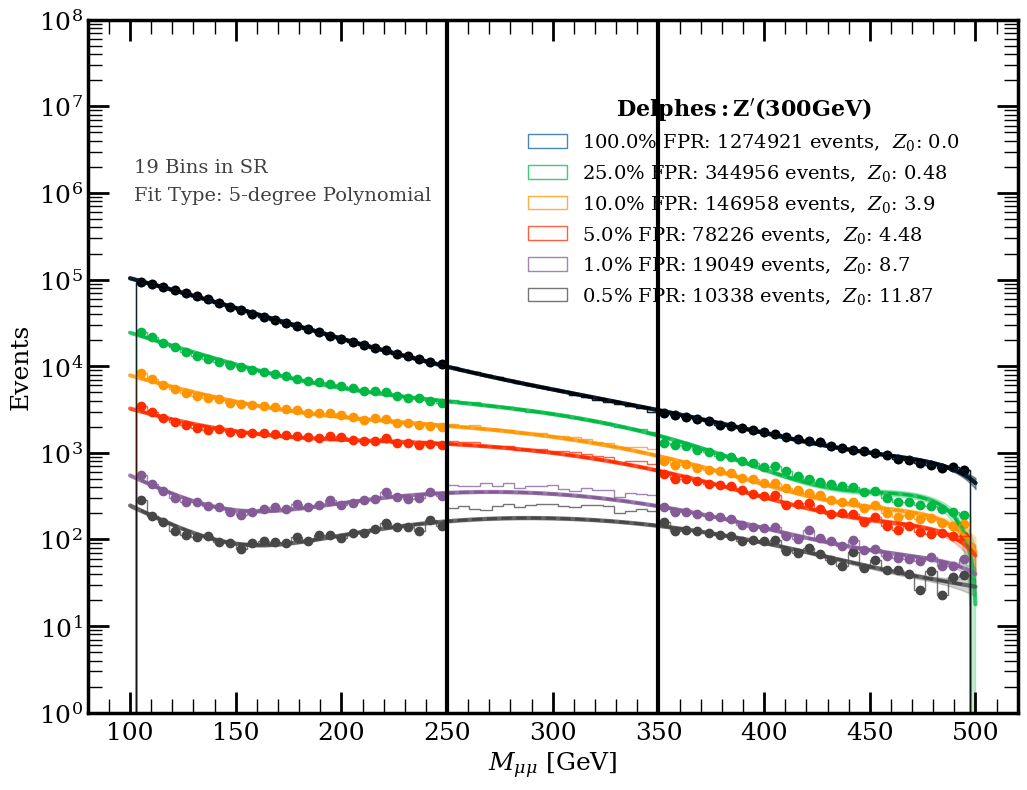

In [20]:
fpr_thresholds = [1.0, 0.25, 0.1, 0.05, 0.01, 0.005]
plot_histograms_with_fits(
    fpr_thresholds,
    data_dict = df_data,
    title = "Toy Model Test",
    SR_left=config['mass-windows']['SR-left'],
    SR_right=config['mass-windows']['SR-right'],
    SB_left=config['mass-windows']['SB-left'],
    SB_right=config['mass-windows']['SB-right'],
    fit_degree=config['fit']['bkg-fit-degree'],
    num_bins_SR=config['mass-windows']['SR-bins'],
    take_score_avg=True,
    ymin = 1,
    ymax = 1e8,
    legend_title = r"$\bf{Delphes: Z^\prime(300 GeV)}$",
    ncpu = 6,
    fit = True
)





In [11]:
146659 + 1197745

1344404

In [ ]:
print(os.environ.get("SLURM_CPUS_ON_NODE"))


In [ ]:
import multiprocessing
print(multiprocessing.cpu_count())